Make nice COS spectra plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from scipy.optimize import leastsq
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
from astropy.io.votable import parse
from dust_extinction.parameter_averages import F99

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20
#from cycler import cycler
#plt.rcParams['axes.prop_cycle'] = cycler(color=[plt.cm.plasma(r)])
# rcParams['image.cmap']='plasma'

In [2]:
import mplcyberpunk

plt.style.use("cyberpunk")

In [3]:
# path = '/media/david/5tb_storage1/cc_cet/hst/data/'
path = '/media/david/2tb_ext_hd/hddata/cc_cet/hst/data/'

x1ds = glob.glob(path+'*x1dsum.fits')
x1ds

['/media/david/2tb_ext_hd/hddata/cc_cet/hst/data/ldlc51010_x1dsum.fits',
 '/media/david/2tb_ext_hd/hddata/cc_cet/hst/data/ldlc01010_x1dsum.fits']

Text(0, 0.5, 'Flux (erg s$^{-1}$ cm$^{-2}$ \\AA$^{-1}$)')

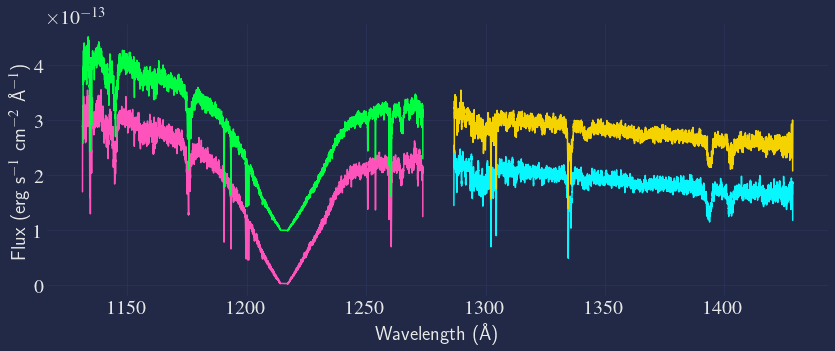

In [4]:
smooth = 5
for i, x in enumerate(x1ds):
    data = fits.getdata(x,1)
    for dt in data:
        w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
        mask = (f>0) & (dq == 0) & (w < 1214) | (w > 1217) & (f>0) & (dq == 0) 
        w, f, e = w[mask], f[mask], e[mask]
        f = convolve(f,Box1DKernel(smooth))
        e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
        plt.plot(w, f+0.5*np.mean(f)*i)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

Just show one spectrum and a bunch of lines?

In [5]:
ism = Table.read('../../ism_lines.csv')
print(ism.dtype.names)
ism = ism[ism['line'] != 'SiIV']

('line', 'rest_lambda')


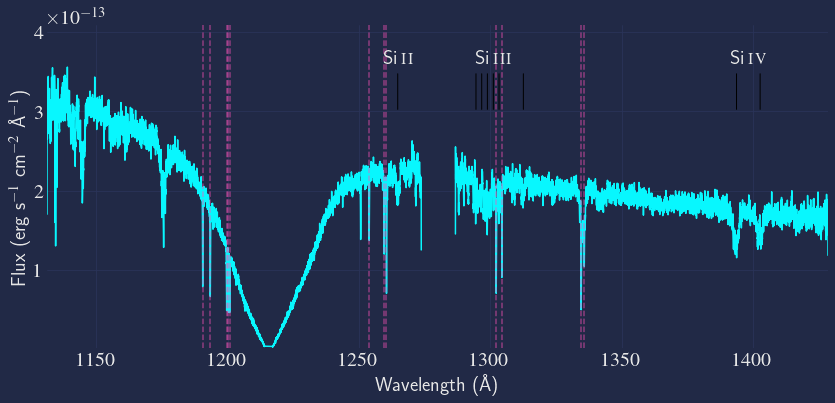

In [6]:
si2 = [1264.738]
si3 = [1294.545,1296.726,1298.892,1301.149,1303.323,1312.591]
si4 = [1393.775,1402.770]
plt.figure(figsize=(12, 6))
smooth = 5
x = x1ds[0]
data = fits.getdata(x,1)
w0, w1 = 10000, 0
for dt in data:
    w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
    mask = (f>0) & (dq == 0) & (w < 1214) | (w > 1217) & (f>0) & (dq == 0) 
    w, f, e = w[mask], f[mask], e[mask]
    if w[0] < w0:
        w0= w[0]
    if w[-1] > w1:
        w1 = w[-1]
    f = convolve(f,Box1DKernel(smooth))
    e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
    plt.plot(w, f, c='C0')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
[plt.axvline(line, ls='--', c='C1', alpha=0.5) for line in ism['rest_lambda']]
plt.xlim(w0, w1)
plt.ylim(0.1e-14, 4.09e-13)

names = ['Si\,{\sc ii}', 'Si\,{\sc iii}', 'Si\,{\sc iv}']
lines = [si2, si3, si4]
for name, si in zip(names, lines):
    [plt.annotate('',(line, 3.e-13), xytext=(line, 3.5e-13),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si]
    plt.annotate(name,(np.mean(si), 3.e-13), xytext=(np.mean(si), 3.6e-13), horizontalalignment='center')
    



#[plt.annotate('',(line, 3.5e-13), xytext=(line, 4e-13),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si3]
#plt.annotate('Si\,{\sc iii}',(np.mean(si3), 3.5e-13), xytext=(np.mean(si3), 4.1e-13), horizontalalignment='center')

#[plt.annotate('',(line, 3.5e-13), xytext=(line, 4e-13),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si4]
#plt.annotate('Si\,{\sc iv}',(np.mean(si4), 3.5e-13), xytext=(np.mean(si4), 4.1e-13), horizontalalignment='center')


plt.tight_layout()
# plt.savefig('plots/cc_cet_cos.pdf')

Looking for variation in the split spectra (try S iv lines)

In [7]:
# smooth=10
# npath = '/media/david/5tb_storage1/cc_cet/hst/newx1ds/'
# nx1ds = glob.glob(npath+'*100*x1d.fits')
# data = fits.getdata(nx1ds[9], 1)[0]
# w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
# f = convolve(f,Box1DKernel(smooth))
# e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
# plt.plot(w, f)
# plt.plot(w,e)
# plt.xlim(1380, 1420)
# plt.ylim(0, 3e-13)

In [8]:
# times  = []
# for x in nx1ds:
#     hdr = fits.getheader(x,1)
#     ti = (hdr['EXPSTART'] + hdr['EXPEND'])/2
#     times.append(ti)
    
# args = np.argsort(np.array(times))
# nx1ds = np.array(nx1ds)[args]
# times = np.array(times)[args]
    

In [9]:
"""from matplotlib.animation import FuncAnimation
smooth=50

fig, ax = plt.subplots(figsize=(5,5))
fig.set_tight_layout(True)

#ax[0].plot(t, f_lc)
#ax[0].set_xlabel('Time (s)')
#ax[0].set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$)')
#ax[0].set_ylim(0.4, 1.2)
ax.set_xlim(1380.1, 1414.9)
ax.set_ylim(1.11e-13, 2.09e-13)

#line, = ax[0].plot([0,0], [-0.1e-12,1.3e-12], 'C1--', linewidth=2)
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.set_xlabel('Wavelength (\AA)')
ax.axvline(1393.775, ls='--', c='C1', alpha=0.5)
ax.axvline(1402.770, ls='--', c='C1', alpha=0.5)
#[ax[1].axvline(line, ls='--', c='r') for line in [8498.02,8542.09,8662.14]]

#ext = hdul[1::][0]
#dt = ext.data[0]
#w, f = dt['WAVELENGTH'], dt['FLUX']
w, f, e = np.array([], dtype=float), np.array([], dtype=float), np.array([], dtype=float)
#w, f, e  = np.loadtxt(csv_files[0], unpack=True, delimiter=',')
line1, = ax.step(w,f, where='mid')
t0 = fits.getheader(nx1ds[0],1)['EXPSTART']
an = ax.annotate('', (0.75, 0.1), xycoords ='axes fraction')
obs = 1
def update(i):
    #time = t[i]
    #line.set_xdata([t[i], t[i]])
    #ext = hdul[1::][i]
    hdr = fits.getheader(nx1ds[i],1)
    ti = (hdr['EXPSTART'] + hdr['EXPEND'])/2
    if ti > 58152:
        obs=2
    else:
        obs = 1
    data = fits.getdata(nx1ds[i],1)[0]
    w, f = data['WAVELENGTH'], data['FLUX']
    f = convolve(f,Box1DKernel(smooth))
    line1.set_xdata(w)
    line1.set_ydata(f)
    
   ## if ti > t0+2:
     #   t0 = ti
      #  obs =
    an.set_text('Ob {0}'.format(obs))
 #   print(ti)
    return ax, line1, an
#ax.legend()
anim = FuncAnimation(fig, update, frames=np.arange(len(nx1ds)), interval=300)
anim.save('hst.gif', dpi=80, writer='imagemagick')
plt.show()

"""

"from matplotlib.animation import FuncAnimation\nsmooth=50\n\nfig, ax = plt.subplots(figsize=(5,5))\nfig.set_tight_layout(True)\n\n#ax[0].plot(t, f_lc)\n#ax[0].set_xlabel('Time (s)')\n#ax[0].set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$)')\n#ax[0].set_ylim(0.4, 1.2)\nax.set_xlim(1380.1, 1414.9)\nax.set_ylim(1.11e-13, 2.09e-13)\n\n#line, = ax[0].plot([0,0], [-0.1e-12,1.3e-12], 'C1--', linewidth=2)\nax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \\AA$^{-1}$)')\nax.set_xlabel('Wavelength (\\AA)')\nax.axvline(1393.775, ls='--', c='C1', alpha=0.5)\nax.axvline(1402.770, ls='--', c='C1', alpha=0.5)\n#[ax[1].axvline(line, ls='--', c='r') for line in [8498.02,8542.09,8662.14]]\n\n#ext = hdul[1::][0]\n#dt = ext.data[0]\n#w, f = dt['WAVELENGTH'], dt['FLUX']\nw, f, e = np.array([], dtype=float), np.array([], dtype=float), np.array([], dtype=float)\n#w, f, e  = np.loadtxt(csv_files[0], unpack=True, delimiter=',')\nline1, = ax.step(w,f, where='mid')\nt0 = fits.getheader(nx1ds[0],1)['EXPSTART']\nan = ax.anno

In [10]:
#gaia
p = 8.23807235942898e-3
pe = 0.07578241768233003e-3

d = 1/p
de = pe/p**2
print(d, de)
print(pe/p)

121.38762035216145 1.116650466958175
0.009199047346991606


3.4725623758204808e-31


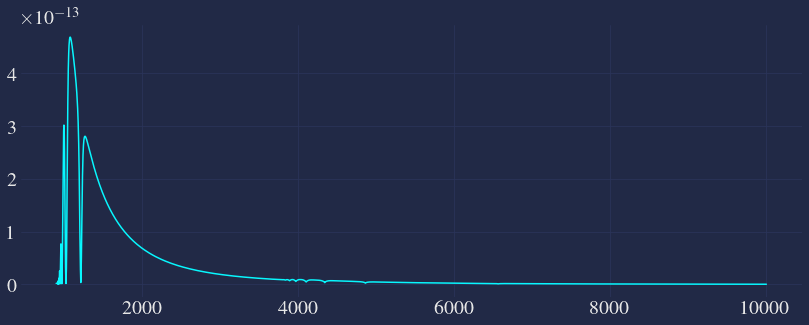

In [11]:
#model 
mw, mf = np.loadtxt('models/ldlc01010.dk', unpack=True, skiprows=34)
#plt.plot(mw, mf)

r = (0.0179*u.Rsun).to(u.m).value
dm = (d*u.pc).to(u.m).value
scale = (np.pi)*((r/dm)**2)*1e-8
print(scale)
plt.plot(mw, mf*scale)

[3.73053027e+30]
[3.61628544e+30 3.61627144e+30 3.61625745e+30 ... 3.38810021e+30
 3.38809657e+30 3.38809293e+30]
[1.06536227]


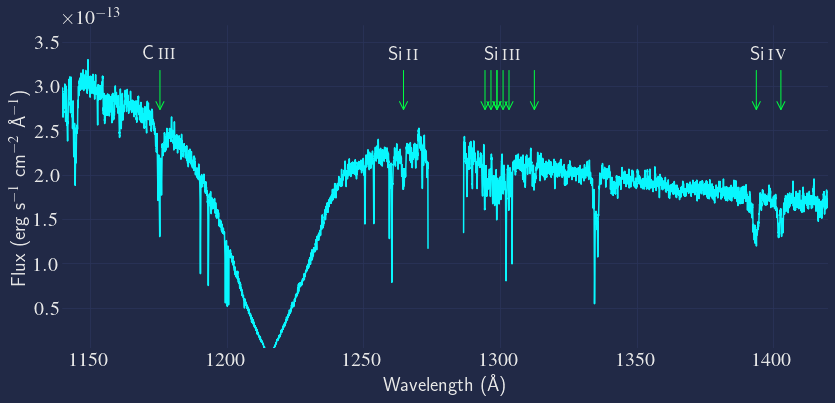

In [37]:
si2 = [1264.738]
si3 = [1294.545,1296.726,1298.892,1298.946, 1301.149,1303.323,1312.591]
si4 = [1393.775,1402.770]
c3 = [1174.935, 1175.265, 1175.592, 1175.713, 1175.713, 1175.989, 1176.372]
plt.figure(figsize=(12, 6))
smooth = 10
x = x1ds[0]
data = fits.getdata(x,1)
wb = np.array([], dtype=float)
fb = np.array([], dtype=float)
eb = np.array([], dtype=float)
for dt in data[::-1]:
    w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
    mask = (f>0) & (dq == 0) & (w < 1214) | (w > 1217) & (f>0) & (dq == 0) 
    w, f, e = w[mask], f[mask], e[mask]
    wb = np.concatenate((wb, w))
    fb = np.concatenate((fb, f))
    eb = np.concatenate((eb, e))    
    f = convolve(f,Box1DKernel(smooth))
    e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
    plt.plot(w, f, c='C0')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# [plt.axvline(line, ls='--', c='C2', alpha=0.5) for line in ism['rest_lambda']]
plt.xlim(1140, 1420)
plt.ylim(0.4e-14, 3.69e-13)


# plt.plot(wb, mf1/(normfac1*normfac2), c='C1', lw=2)
plt.plot([1000, 1500], [3.75e-13, 3.75e-13], c='C1')
# mplcyberpunk.add_glow_effects()
# mplcyberpunk.make_lines_glow()
# mplcyberpunk.add_underglow()

names = ['Si\,{\sc ii}', 'Si\,{\sc iii}', 'Si\,{\sc iv}', 'C\,{\sc iii}']
lines = [si2, si3, si4, [np.mean(c3)]]
for name, si in zip(names, lines):
    # [plt.axvline(line, ls='--', c='C3', alpha=0.5, zorder=-10) for line in si]
    [plt.annotate('',(line, 2.7e-13), xytext=(line, 3.2e-13),arrowprops=dict(arrowstyle='->', color='C3'), horizontalalignment='center') for line in si]
    plt.annotate(name,(np.mean(si), 3.e-13), xytext=(np.mean(si), 3.3e-13), horizontalalignment='center', bbox=dict(facecolor='none', edgecolor='none', alpha=0.5))

    

def residuals(scale, f, mf):
    return f - mf/scale
    
mmask = (mw > wb[0]) & (mw < wb[-1])
mw1, mf1 = mw[mmask], mf[mmask]


mf1 = interp1d(mw1, mf1, fill_value='extrapolate')(wb)

alllines = np.hstack((si2, si3, si4, c3, ism['rest_lambda']))

C = np.zeros_like(wb,dtype='bool')
for a in alllines:
    C |= (wb> a-0.5)&(wb <a+0.5)
mask = ~C

normfac = leastsq(residuals, 1., args=(fb[mask], mf1[mask]))[0]

print(normfac)


# define the model
ext = F99(Rv=3.1)

p = 8.23807235942898e-3
r = (0.0179*u.Rsun).to(u.m)
dm = ((1/p)*u.pc).to(u.m)
red = ext.extinguish(wb*u.AA, Ebv=0.021)

normfac1 = (1e8)/(np.pi*((r/dm)**2)*red)
print(normfac1)    
    
normfac2 = leastsq(residuals, 1., args=(fb[mask], (mf1/normfac1)[mask]))[0]
print(normfac2)
    

plt.tight_layout()
# plt.savefig('plots/cc_cet_cos.pdf', dpi=300)
plt.savefig('plots/cp_plots/cc_cet_cos_cp_noglow.png',dpi=150)

In [13]:
"""x = x1ds[1]
data = fits.getdata(x,1)
for dt in data[::-1]:
    w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
    plt.plot(w, f)
    
w2, f2, e2, dq2 = np.loadtxt('CC-Cet_ldlc51010.dat', unpack=True)
plt.plot(w2, f2)
plt.xlim(1300, 1350)
plt.ylim(0, 0.5e-12)"""

"x = x1ds[1]\ndata = fits.getdata(x,1)\nfor dt in data[::-1]:\n    w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']\n    plt.plot(w, f)\n    \nw2, f2, e2, dq2 = np.loadtxt('CC-Cet_ldlc51010.dat', unpack=True)\nplt.plot(w2, f2)\nplt.xlim(1300, 1350)\nplt.ylim(0, 0.5e-12)"

In [14]:
"""x = '/media/david/5tb_storage1/pceb_data/ldlc04010_x1dsum.fits'
data = fits.getdata(x,1)
rootname = fits.getheader(x, 0)['ASN_ID']
wb = np.array([], dtype=float)
fb = np.array([], dtype=float)
eb = np.array([], dtype=float)
dqb = np.array([], dtype=int)
for dt in data[::-1]:
    w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
   # mask = (f>0) & (dq == 0) & (w < 1214) | (w > 1217) & (f>0) & (dq == 0) 
    #w, f, e = w[mask], f[mask], e[mask]
    wb = np.concatenate((wb, w))
    fb = np.concatenate((fb, f))
    eb = np.concatenate((eb, e))
    dqb = np.concatenate((dqb, dq))
savdat = Table([wb, fb, eb, dqb], names=['#WAVELENGTH', 'FLUX', 'ERROR', 'DQ'])
ascii.write(savdat, 'LM-COM_'+rootname.lower()+'.dat', format='basic', overwrite=True)"""

"x = '/media/david/5tb_storage1/pceb_data/ldlc04010_x1dsum.fits'\ndata = fits.getdata(x,1)\nrootname = fits.getheader(x, 0)['ASN_ID']\nwb = np.array([], dtype=float)\nfb = np.array([], dtype=float)\neb = np.array([], dtype=float)\ndqb = np.array([], dtype=int)\nfor dt in data[::-1]:\n    w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']\n   # mask = (f>0) & (dq == 0) & (w < 1214) | (w > 1217) & (f>0) & (dq == 0) \n    #w, f, e = w[mask], f[mask], e[mask]\n    wb = np.concatenate((wb, w))\n    fb = np.concatenate((fb, f))\n    eb = np.concatenate((eb, e))\n    dqb = np.concatenate((dqb, dq))\nsavdat = Table([wb, fb, eb, dqb], names=['#WAVELENGTH', 'FLUX', 'ERROR', 'DQ'])\nascii.write(savdat, 'LM-COM_'+rootname.lower()+'.dat', format='basic', overwrite=True)"

Making plots with the magnetic models

In [15]:

mods = glob.glob('magnetic_models/*1400*.dat')
mods.sort()
print(mods)

['magnetic_models/cccet-1400-B630kG-40kms-01-plot.dat', 'magnetic_models/cccet-1400-B710kG-40kms-02-plot.dat', 'magnetic_models/lmcom-1400-0kG-plot.dat']


Adding another spectrum to compare with

In [16]:
"""def make_plot_spec(w, f, e, mask1, mask2): #cuts spectrum down to the bit to plot
    fitter = fitting.LinearLSQFitter()
    #mask = (w > 8450) & (w < 8480) | (w > 8520) & (w <8540) | (w > 8560) & (w< 8660) | (w > 8680) & (w < 8700) #mask out emmission lines
    w1, f1 = w[mask1], f[mask1]
    n_init = models.Polynomial1D(3)
    n_fit = fitter(n_init, w1, f1)
    #mask = (w > 8450) & (w < 8700)
    w1, f1, e1 = w[mask2], f[mask2], e[mask2]
    nf = f1/n_fit(w1)
    ne = e1/n_fit(w1)
    smooth = 5
    nf = convolve(nf,Box1DKernel(smooth))
    ne = convolve(ne,Box1DKernel(smooth))/smooth**0.5
    return w1,nf, ne

wc, fc, ec, dqc = np.loadtxt('LM-COM_ldlc04010.dat', unpack=True) #picking lm com for now, might change!
mask2 = (wc > 1390) & (wc < 1410)
mask1 = (wc > 1390) & (wc < 1392) | (wc > 1395) & (wc < 1401) | (wc > 1405) & (wc < 1410)
wn, fn, en = make_plot_spec(wc, fc, ec, mask1, mask2)
plt.plot(wn, fn)"""

"def make_plot_spec(w, f, e, mask1, mask2): #cuts spectrum down to the bit to plot\n    fitter = fitting.LinearLSQFitter()\n    #mask = (w > 8450) & (w < 8480) | (w > 8520) & (w <8540) | (w > 8560) & (w< 8660) | (w > 8680) & (w < 8700) #mask out emmission lines\n    w1, f1 = w[mask1], f[mask1]\n    n_init = models.Polynomial1D(3)\n    n_fit = fitter(n_init, w1, f1)\n    #mask = (w > 8450) & (w < 8700)\n    w1, f1, e1 = w[mask2], f[mask2], e[mask2]\n    nf = f1/n_fit(w1)\n    ne = e1/n_fit(w1)\n    smooth = 5\n    nf = convolve(nf,Box1DKernel(smooth))\n    ne = convolve(ne,Box1DKernel(smooth))/smooth**0.5\n    return w1,nf, ne\n\nwc, fc, ec, dqc = np.loadtxt('LM-COM_ldlc04010.dat', unpack=True) #picking lm com for now, might change!\nmask2 = (wc > 1390) & (wc < 1410)\nmask1 = (wc > 1390) & (wc < 1392) | (wc > 1395) & (wc < 1401) | (wc > 1405) & (wc < 1410)\nwn, fn, en = make_plot_spec(wc, fc, ec, mask1, mask2)\nplt.plot(wn, fn)"

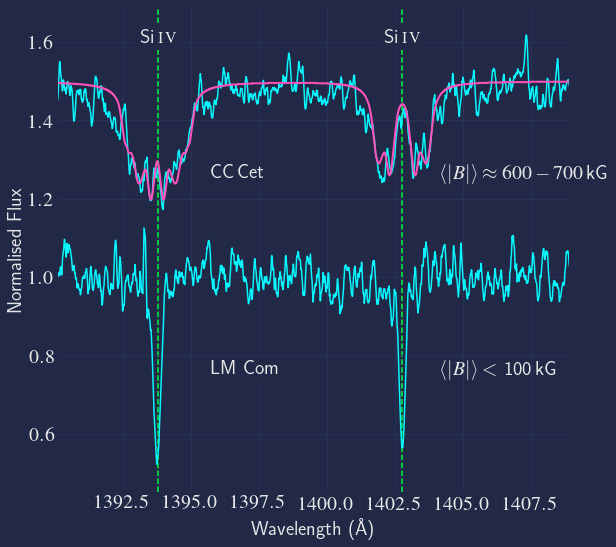

In [125]:
mods = ['magnetic_models/lmcom-1400-0kG-plot.dat', 'magnetic_models/cccet-1400-B710kG-40kms-02-plot.dat', 'magnetic_models/cccet-1400-B630kG-40kms-01-plot.dat']


si4 = [1393.775,1402.770]
# dates = ['LM Com \n 2017~December~17','CC\,Cet \n 2018~July~22', 'CC\,Cet \n 2018~February~01']
dates = ['LM Com ','CC\,Cet', 'CC\,Cet ']
Bs = ['100', '600-700', 630]

plt.figure(figsize = (9, 8))
for i, mod in enumerate(mods[:2]):
    w, f, m = np.loadtxt(mod, unpack=True)
    f = convolve(f,Box1DKernel(10))
    if i == 0:
        mask = (w <   1393.280) | (w > 1393.310)
        w, f, m = w[mask], f[mask], m[mask]
    plt.plot(w,f+0.5*i, c='C0')
    if i > 0:
        plt.plot(w, m+0.5*i, lw=2, c='C1')
    
#     if i == 2:
#         plt.fill_between(w, 0, f+0.5*i, color='C4', alpha=0.1, zorder=-100)
        #[plt.annotate('',(line, 2.7e-13), xytext=(line, 3.2e-13),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si4]
    #    plt.xticks(visible=False)
    plt.xlim(1390.1, 1408.9)
    plt.ylabel('Normalised Flux')
    if i == 1:
        plt.xlabel('Wavelength (\AA)')
    plt.annotate(dates[i], (0.3, 0.75+(0.5*i)), xycoords = ('axes fraction', 'data'), bbox=dict(facecolor='#212946', edgecolor='none'))
    if i > 0:
        plt.annotate(r'$\langle \vert B \vert \rangle \approx {}$\,kG'.format(Bs[i]), (0.75, 0.75+(0.5*i)), xycoords = ('axes fraction', 'data'))
    else:
        plt.annotate(r'$\langle \vert B \vert \rangle  <$ {}\,kG'.format(Bs[i]), (0.75, 0.75+(0.5*i)), xycoords = ('axes fraction', 'data'))
plt.ylim(0.45, 1.69)

#plt.plot(wn, fn+1)
[plt.axvline(line, ls='--', c='C3', zorder=-10) for line in si4]
[plt.annotate('Si\,{\sc iv}',(line, 1), xytext=(line, 1.6), horizontalalignment='center', bbox=dict(facecolor='#212946', edgecolor='none', alpha=1)) for line in si4]
#plt.annotate('LM Com', (0.75, 1.8), xycoords = ('axes fraction', 'data'), bbox=dict(facecolor='white', edgecolor='none'))

# mplcyberpunk.add_glow_effects()
# mplcyberpunk.make_lines_glow()
# mplcyberpunk.add_underglow()
plt.tight_layout()
# plt.subplots_adjust(hspace=0.02)
# plt.savefig('plots/siiv_lines.pdf', dpi=300)
# plt.savefig('plots/siiv_lines.png', dpi=150, facecolor='white')
plt.savefig('plots/cp_plots/siiv_lines_cp_mod.png',dpi=300)
    #plt.show()


In [18]:
mods = glob.glob('magnetic_models/cccet*1300*.dat')
#mods.sort()
mods = mods[::-1]
print(mods)

['magnetic_models/cccet-1300-B710kG-40kms-02-plot.dat', 'magnetic_models/cccet-1300-B630kG-40kms-01-plot.dat']


In [19]:
# dates = ['2018~July~22', '2018~February~01']
# Bs = [710, 630]

# si3 = [1294.545,1296.726,1298.892,1298.946,1301.149,1303.323]#,1312.591]

# plt.figure(figsize = (10, 10))
# for i, mod in enumerate(mods):
#     w, f, m = np.loadtxt(mod, unpack=True)
#     f = convolve(f,Box1DKernel(5))
#     plt.plot(w,f+0.5*i, c='C0')
#     plt.plot(w, m+0.5*i, lw=2, c='C1')
    
#     plt.xlim(1292.1, 1307.9)
#     plt.ylabel('Normalised Flux')
#     if i == 1:
#         plt.xlabel('Wavelength (\AA)')
#     plt.annotate(dates[i], (0.02, 0.67+(0.55*i)), xycoords = ('axes fraction', 'data'), bbox=dict(facecolor='white', edgecolor='none'))
#     plt.annotate(r'$\langle \vert B \vert \rangle  <$ {}\,kG'.format(Bs[i]), (0.77, 0.67+(0.55*i)), xycoords = ('axes fraction', 'data'))
# plt.ylim(0.61, 1.69)

# #plt.plot(wn, fn+1)
# [plt.axvline(line, ls='--', c='C2', alpha=0.5) for line in si3]
# [plt.annotate('Si\,{\sc iii}',(line, 1), xytext=(line, 1.6), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none')) for line in si3]
# #plt.annotate('LM Com', (0.75, 1.8), xycoords = ('axes fraction', 'data'), bbox=dict(facecolor='white', edgecolor='none'))
# plt.tight_layout()
# # plt.subplots_adjust(hspace=0.02)
# # plt.savefig('plots/nolm_siiii_lines.pdf')

See what it looks like with LM com as well

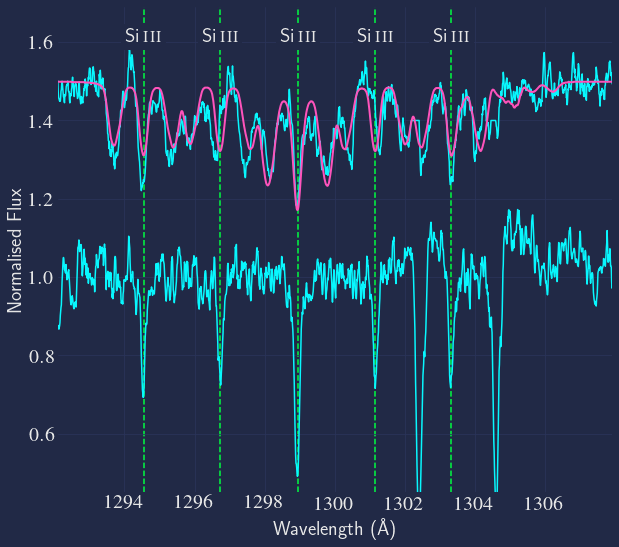

In [126]:
mods = ['magnetic_models/lmcom-1300-0kG-plot.dat','magnetic_models/cccet-1300-B710kG-40kms-02-plot.dat', 'magnetic_models/cccet-1300-B630kG-40kms-01-plot.dat']

# dates = ['LM Com \n 2017~December~17','CC\,Cet \n 2018~July~22', 'CC\,Cet \n 2018~February~01']
dates = ['LM Com ','CC\,Cet', 'CC\,Cet ']
Bs = ['100', '600-700', 630]
si3 = [1294.545,1296.726,1298.946,1301.149,1303.323]#,1312.591]
plt.figure(figsize = (9, 8))
for i, mod in enumerate(mods[:2]):
    w, f, m = np.loadtxt(mod, unpack=True)
    f = convolve(f,Box1DKernel(5))
    if i == 0:
        mask = (w <   1393.280) | (w > 1393.310)
        w, f, m = w[mask], f[mask], m[mask]
    plt.plot(w,f+0.5*i, c='C0')
    if i > 0:
        plt.plot(w, m+0.5*i, lw=2, c='C1')
    
    #if i == 0:
        #[plt.annotate('',(line, 2.7e-13), xytext=(line, 3.2e-13),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si4]
    #    plt.xticks(visible=False)
    plt.xlim(1292.1, 1307.9)
    plt.ylabel('Normalised Flux')
    if i == 1:
        plt.xlabel('Wavelength (\AA)')
   
    # if i > 0:
        # plt.annotate(r'$\langle \vert B \vert \rangle \approx {}$\,kG'.format(Bs[i]), (0.75, 0.7+(0.5*i)), xycoords = ('axes fraction', 'data'), bbox=dict(facecolor='#212946', edgecolor='none'))
        # plt.annotate(dates[i], (0.02, 0.65+(0.5*i)), xycoords = ('axes fraction', 'data'), bbox=dict(facecolor='#212946', edgecolor='none'))
    # else:
        # plt.annotate(r'$\langle \vert B \vert \rangle  <$ {}\,kG'.format(Bs[i]), (0.75, 0.65+(0.5*i)), xycoords = ('axes fraction', 'data'), bbox=dict(facecolor='#212946', edgecolor='none'))
        # plt.annotate(dates[i], (0.02, 0.6+(0.5*i)), xycoords = ('axes fraction', 'data'), bbox=dict(facecolor='#212946', edgecolor='none'))
plt.ylim(0.45, 1.69)

#plt.plot(wn, fn+1)
[plt.axvline(line, ls='--', c='C3', zorder=-10) for line in si3]
# plt.axvline(1298.892, ls='--', c='C3', alpha=0.5)
[plt.annotate('Si\,{\sc iii}',(line, 1), xytext=(line,1.6), horizontalalignment='center', bbox=dict(facecolor='#212946', edgecolor='none', alpha=1)) for line in si3]
#plt.annotate('LM Com', (0.75, 1.8), xycoords = ('axes fraction', 'data'), bbox=dict(facecolor='white', edgecolor='none'))
# mplcyberpunk.make_lines_glow()
plt.tight_layout()
#plt.subplots_adjust(hspace=0.02)
# plt.savefig('plots/siiii_lines.pdf', dpi=300)
# plt.savefig('plots/siiii_lines.png', dpi=150, facecolor='white')
plt.savefig('plots/cp_plots/siiii_lines_cp_mod.png',dpi=300)

Saving a scaled model for use in the COS etc.

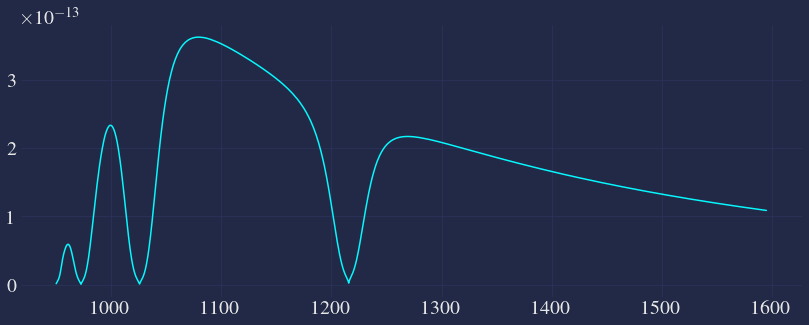

In [21]:
mmask = (mw > 950) & (mw < 1600) #safe side to overlap g130m
mws, mfs = mw[mmask], mf[mmask]/normfac
plt.plot(mws, mfs)
savdat = Table([mws, mfs], names=['#WAVELENGTH', 'FLUX'])
ascii.write(savdat, 'models/CC_CET_scaled_fuv_model.dat', format='basic', overwrite=True)

20210119 what are the lines around 1140?

(1130.0, 1150.0)

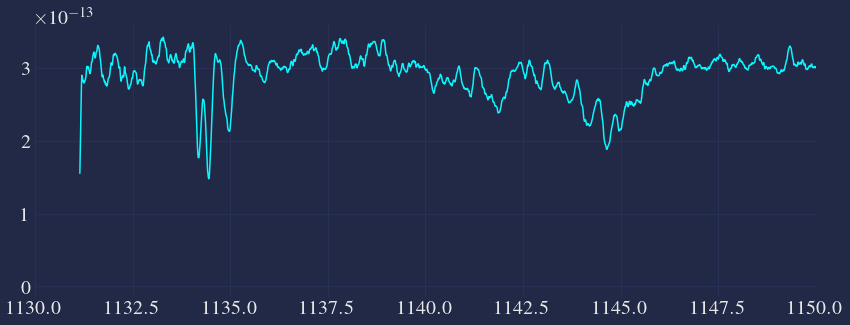

In [22]:
x = x1ds[0]
data = fits.getdata(x,1)
wb = np.array([], dtype=float)
fb = np.array([], dtype=float)
eb = np.array([], dtype=float)
for dt in data[::-1]:
    w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
    mask = (f>0) & (dq == 0) & (w < 1214) | (w > 1217) & (f>0) & (dq == 0) 
    w, f, e = w[mask], f[mask], e[mask]
    wb = np.concatenate((wb, w))
    fb = np.concatenate((fb, f))
    eb = np.concatenate((eb, e))    
    f = convolve(f,Box1DKernel(smooth))
    e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
    plt.plot(w, f, c='C0')
plt.xlim(1130, 1150)

Can the M4 emmmison lines poke through? Compare with GJ1214 (M5V from MUSCLES).

In [23]:
# muspath = '/media/david/5tb_storage1/mast_muscles/gj1214/'
# spec = 'hlsp_muscles_multi_multi_gj1214_broadband_v22_adapt-var-res-sed.fits'
# gjdat = fits.getdata(muspath+spec)
# gjw, gjf = gjdat['WAVELENGTH'], gjdat['FLUX']
# plt.plot(gjw, gjf)

In [24]:
# gjmask = (gjw > w[0]) & (gjw < w[-1]) 
# gjw1, gjf1 = gjw[gjmask], gjf[gjmask]

# gj_d = 14.65*u.pc
# cc_d = 121.4*u.pc

# scale = (gj_d/cc_d)**2
# scale

In [25]:
# plt.plot(w,f)
# plt.plot(gjw1, gjf1*scale)

Making an SED. First scale a template spectrum.

In [26]:
tphot = 'cc_cet_vizier_votable.vot'
c = 2.998e8*u.m/u.s



votable = parse(tphot)
table = votable.get_first_table()
data = table.array
mask = ~data['sed_eflux'].mask
masked_data = data[mask].data
filters = np.unique(masked_data['sed_filter'].data)
wp = []
fp = []
ep = []
#print(filters)

# filters = [b'2MASS:H', b'2MASS:J', b'2MASS:Ks', b'GALEX:FUV',
#            b'GALEX:NUV', b'Gaia:G', b'Johnson:B', b'Johnson:H', b'Johnson:J',
#            b'Johnson:K', b'Johnson:V', b'PAN-STARRS/PS1:g', b'PAN-STARRS/PS1:i',
#            b'PAN-STARRS/PS1:r', b'PAN-STARRS/PS1:y', b'PAN-STARRS/PS1:z', b"SDSS:g'", 
#            b"SDSS:r'", b'WISE:W1', b'WISE:W2'] #picking my own

# filters = [b'2MASS:H', b'2MASS:J', b'2MASS:Ks', b'GALEX:FUV',
#            b'GALEX:NUV', b'PAN-STARRS/PS1:g', b'PAN-STARRS/PS1:i',
#            b'PAN-STARRS/PS1:r', b'PAN-STARRS/PS1:y', b'PAN-STARRS/PS1:z']#, b'WISE:W1', b'WISE:W2'] #picking my own

filters = [b'GALEX:FUV',
           b'GALEX:NUV', b'PAN-STARRS/PS1:g', b'PAN-STARRS/PS1:i',
           b'PAN-STARRS/PS1:r', b'PAN-STARRS/PS1:y', b'PAN-STARRS/PS1:z']
#filters = [b'GALEX:NUV']


for flt in filters:
    w1 = (np.mean(masked_data['sed_freq'][masked_data['sed_filter']==flt])*u.GHz).to(u.AA, equivalencies=u.spectral())
    fj1 = masked_data['sed_flux'][masked_data['sed_filter']==flt]
    e1 = masked_data['sed_eflux'][masked_data['sed_filter']==flt]
    if len(fj1) >1:
        fj_av = np.average(fj1, weights = (1/(e1**2)))
        e1_av = abs(np.average((fj1-fj_av), weights = (1/(e1**2))))**0.5
        e1_av = 1 / np.sum(1/(e1**2), axis=0)**0.5
    else:
        fj_av, e1_av = fj1[0], e1[0]
    f1 = (fj_av*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(w1)) 
    wp.append(w1.value)
    fp.append(f1.value)
    e1 = ((e1_av*f1)/fj_av).value
    ep.append(e1)

wp, fp, ep = np.array(wp), np.array(fp), np.array(ep)

/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
temp_path = '/media/david/5tb_storage1/pyhammer/PyHammer-2.0.0/resources/templates/'
specs = glob.glob('{}M4_+0.0_Dwarf.fits'.format(temp_path))
data = fits.getdata(specs[0])
tempscale= 3e-16
wt, ft = 10**data['Loglam'], data['Flux']*tempscale

mwt, mft = mw[mw >wt[0]], mf[mw > wt[0]]/normfac

plt.plot(wt, ft*tempscale)
plt.plot(mwt, mft)
ftm = interp1d(wt, ft, fill_value='extrapolate')(mwt)
plt.plot(mwt, ftm)
plt.errorbar(wp[ep>0], fp[ep>0], yerr=ep[ep>0], marker='o', ls='none', c='C0')
plt.xlim(mwt[0], mwt[-1])
plt.ylim(0, 0.6e-14)
com_f = mft+ftm
plt.plot(mwt, com_f)


specs = glob.glob('{}M5_+0.0_Dwarf.fits'.format(temp_path))
data = fits.getdata(specs[0])
tempscale= 3e-16
wt, ft = 10**data['Loglam'], data['Flux']*tempscale

mwt, mft = mw[mw >wt[0]], mf[mw > wt[0]]/normfac

plt.plot(wt, ft*tempscale)
ftm = interp1d(wt, ft, fill_value='extrapolate')(mwt)
plt.plot(mwt, ftm)
com_f = mft+ftm
plt.plot(mwt, com_f)

In [ ]:

plt.figure(figsize=(12,6))

plt.plot(mw, mf/normfac, c='C1', zorder=10)
# plt.plot(w,f)
x = x1ds[0]
data = fits.getdata(x,1)
wb = np.array([], dtype=float)
fb = np.array([], dtype=float)
eb = np.array([], dtype=float)
for dt in data[::-1]:
    w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
    mask = (f>0) & (dq == 0) & (w < 1214) | (w > 1217) & (f>0) & (dq == 0) 
    w, f, e = w[mask], f[mask], e[mask]
    wb = np.concatenate((wb, w))
    fb = np.concatenate((fb, f))
    eb = np.concatenate((eb, e))    
    f = convolve(f,Box1DKernel(smooth))
    e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
    plt.plot(w, f, c='C0')
# plt.plot(gjw, gjf)
plt.yscale('log')
plt.xscale('log')
plt.xlim(1000, 50000)




plt.errorbar(wp[ep>0], fp[ep>0], yerr=ep[ep>0], marker='o', ls='none', c='C3')

plt.xlim(1051, 9999)
plt.ylim(1e-16)


uves_path =  '/media/david/5tb_storage1/cc_cet/uves/'
dats = glob.glob('{}/*.dat'.format(uves_path))
dat = dats[0]
w, f, e = np.loadtxt(dat, unpack=True)
f = convolve(f,Box1DKernel(20))
plt.plot(w[5:-6], f[5:-6])

temp_path = '/media/david/5tb_storage1/pyhammer/PyHammer-2.0.0/resources/templates/'
specs = glob.glob('{}M5_+0.0_Dwarf.fits'.format(temp_path))
data = fits.getdata(specs[0])
tempscale= 1e-15
plt.plot(10**data['Loglam'], data['Flux']*tempscale,c='C3')
#plt.yscale('log')
#plt.xscale('log')

plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.xlabel('Wavelength (\AA)')

#plt.plot(mw[mw>1400] , mf[mw>1400]/normfac)
#plt.xlim(1200, 60000)
#plt.xticks((2000, 10000, 40000), ('2000', '10000', '40000'))
plt.tight_layout()     
#plt.axvline(2311)
#plt.savefig('plots/cc_cet_phot.png', dpi=150, facecolor='white')
plt.plot(mwt, com_f)

Huh. Plot of the Si 1264 line

[1264.249314443785, 1265.2106855562151]


 [astropy.modeling.fitting]
 [astropy.modeling.fitting]


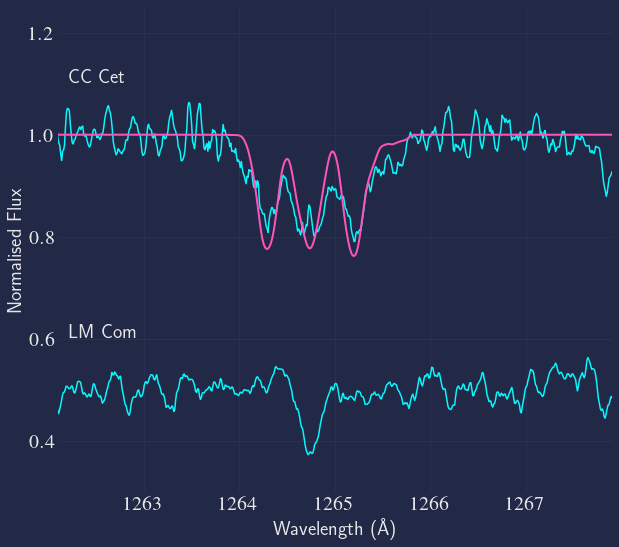

In [111]:
def make_plot_model(w, f, e, mask1, mask2): #cuts spectrum down to the bit to plot
    fitter = fitting.LinearLSQFitter()
    # print(len(w))
    w1, f1, m1 = w[mask1], f[mask1], e[mask1]
    n_init = models.Polynomial1D(3)
    n_fit = fitter(n_init, w1, f1)
    n_fit2 = fitter(n_init, w1, m1)
    #mask = (w > 8450) & (w < 8700)
    w1, f1, m1 = w[mask2], f[mask2], e[mask2]
    nf = f1/n_fit(w1)
    
    nm = m1/n_fit2(w1)
    return w1,nf,nm


mods = ['magnetic_models/plot-obs-model-si2-1265.dat']

# dates = ['2018~July~22', '2018~February~01']
# Bs = [710, 630]

# si3 = [1294.545,1296.726,1298.892,1301.149,1303.323]#,1312.591]

def picomps(l0, B, z=1.43):
    """
    Returns the pi components of a zeeman-split line l0 for magnetic field B 
    """
    dl = 4.67e-13 * z* l0**2 * B
    return [l0-dl, l0+dl]

si2 = [1264.73]

pis = picomps(si2[0], 450e3)
print(pis)
                   
fig, ax = plt.subplots(figsize = (9,8))
for i, mod in enumerate(mods):
    w, f, m = np.loadtxt(mod, unpack=True)
    mask1 = (w > 1262) & (w < 1263.5) | (w > 1266) & (w < 1267) 
    mask2 = (w> 1261) & (w < 1269) 
    w, f, m =  make_plot_model(w, f,m , mask1, mask2)
    f = convolve(f,Box1DKernel(5))

    plt.plot(w,f, c='C0')
    plt.plot(w, m, lw=2, c='C1')
    
#pidispaly = ax.transData.transform(pis[1]-pis[0])
#print(pidisplay)


#[plt.axvline(line, ls='--', c='C2', alpha=0.5) for line in si2]
#[plt.axvline(line, ls='--', c='C2', alpha=0.5) for line in pis]

# plt.annotate('Si\,{\sc ii}\n$\pi$', (si2[0], 1.09),xytext=(si2[0], 1.13), ha='center',bbox=dict(facecolor='#212946', edgecolor='none')) #arrowprops=dict(arrowstyle='-[,widthB=2.6,lengthB=1.2')
# plt.annotate('$\sigma-$', (pis[0], 1.05), ha='center', bbox=dict(facecolor='#212946', edgecolor='none'))
# plt.annotate('$\sigma+$', (pis[1], 1.05), ha='center', bbox=dict(facecolor='#212946', edgecolor='none'))


#add lm com

lmw, lmf, lme, lmdq = np.loadtxt('../hst_spectra/lm_com_COS_FUV_1291_2017-12-17.dat', unpack=True) 
lmw, lmf, lme = lmw[lmdq==0], lmf[lmdq==0], lme[lmdq==0]
# plt.plot(lmw, lmf)
mask3 = (lmw > 1262) & (lmw < 1263.5) | (lmw > 1266) & (lmw < 1267) 
mask4 = (lmw> 1261) & (lmw < 1269) 
# print(len(mask1))
lmw, lmf, lme =  make_plot_model(lmw, lmf, lme , mask3, mask4)


lmf = convolve(lmf,Box1DKernel(smooth))
lme = convolve(lme,Box1DKernel(smooth))/(smooth**0.5)
plt.xlim(1262.1, 1267.9)
plt.ylim(0.9e-13, 1.4e-13)

plt.plot(lmw*1.0002, lmf-0.5)

# [plt.axvline(line, ls='--', c='C3', zorder=-10) for line in si2]


plt.xlim(1262.1, 1267.9)
plt.ylim(0.3, 1.25)
plt.ylabel('Normalised Flux')
plt.xlabel('Wavelength (\AA)')

# plt.axvline(si2[0])

plt.annotate('CC Cet', (0.02, 1.1), xycoords = ('axes fraction', 'data'))
plt.annotate('LM Com', (0.02, 0.6), xycoords = ('axes fraction', 'data'))


# plt.plot([si2[0], 1264.], [0.37, 1.25], ls='--', c='C3' )
# plt.plot([si2[0], 1265.5], [0.37, 1.25], ls='--', c='C3' )


plt.tight_layout()

plt.savefig('plots/cp_plots/si2_cp_model.png', dpi=150)

In [ ]:
t1 = 25245.
t1e=18.5
t2=25162.
t2e=19.5
paper = 25203
paper_e = 42 
wm = ((t1/t1e) + (t2/t2e))/((1/t1e)+(1/t2e))
print('value in paper', '{}+/-{}'.format(paper, paper_e))
print('weighted mean',wm)
print('mean', np.mean([t1,t2]))
print('std', np.std([t1, t2]))

In [95]:
1264.73- 1263.89

0.8399999999999181

In [96]:
1264.73 + 0.84

1265.57

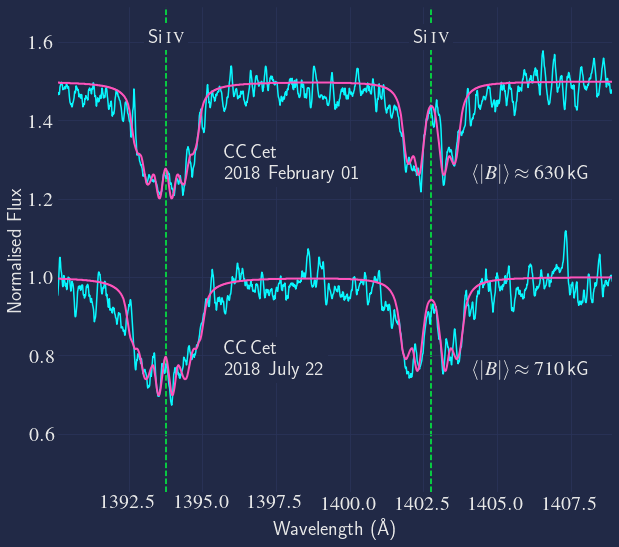

In [138]:
mods = ['magnetic_models/lmcom-1400-0kG-plot.dat', 'magnetic_models/cccet-1400-B710kG-40kms-02-plot.dat', 'magnetic_models/cccet-1400-B630kG-40kms-01-plot.dat']


si4 = [1393.775,1402.770]
dates = ['LM Com \n 2017~December~17','CC\,Cet \n 2018~July~22', 'CC\,Cet \n 2018~February~01']
# dates = ['LM Com ','CC\,Cet', 'CC\,Cet ']
Bs = [710 , 630]

plt.figure(figsize = (9, 8))
for i, mod in enumerate(mods[1:]):
    w, f, m = np.loadtxt(mod, unpack=True)
    f = convolve(f,Box1DKernel(10))
    if i == 0:
        mask = (w <   1393.280) | (w > 1393.310)
        w, f, m = w[mask], f[mask], m[mask]
    plt.plot(w,f+0.5*i, c='C0')
    # if i > 0:
    plt.plot(w, m+0.5*i, lw=2, c='C1')
    
#     if i == 2:
#         plt.fill_between(w, 0, f+0.5*i, color='C4', alpha=0.1, zorder=-100)
        #[plt.annotate('',(line, 2.7e-13), xytext=(line, 3.2e-13),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si4]
    #    plt.xticks(visible=False)
    plt.xlim(1390.1, 1408.9)
    plt.ylabel('Normalised Flux')
    # if i == 1:
    plt.annotate(dates[i+1], (0.3, 0.75+(0.5*i)), xycoords = ('axes fraction', 'data'), bbox=dict(facecolor='#212946', edgecolor='none'))
    # if i > 0:
    plt.annotate(r'$\langle \vert B \vert \rangle \approx {}$\,kG'.format(Bs[i]), (0.75, 0.75+(0.5*i)), xycoords = ('axes fraction', 'data'))
   # else:
        # plt.annotate(r'$\langle \vert B \vert \rangle  <$ {}\,kG'.format(Bs[i]), (0.75, 0.75+(0.5*i)), xycoords = ('axes fraction', 'data'))
plt.ylim(0.45, 1.69)
plt.xlabel('Wavelength (\AA)')

#plt.plot(wn, fn+1)
[plt.axvline(line, ls='--', c='C3', zorder=-10) for line in si4]
[plt.annotate('Si\,{\sc iv}',(line, 1), xytext=(line, 1.6), horizontalalignment='center', bbox=dict(facecolor='#212946', edgecolor='none', alpha=1)) for line in si4]
#plt.annotate('LM Com', (0.75, 1.8), xycoords = ('axes fraction', 'data'), bbox=dict(facecolor='white', edgecolor='none'))

# mplcyberpunk.add_glow_effects()
# mplcyberpunk.make_lines_glow()
# mplcyberpunk.add_underglow()
plt.tight_layout()
# plt.subplots_adjust(hspace=0.02)
# plt.savefig('plots/siiv_lines.pdf', dpi=300)
# plt.savefig('plots/siiv_lines.png', dpi=150, facecolor='white')
plt.savefig('plots/cp_plots/siiv_lines_cp_2spec.png',dpi=150)
    #plt.show()
